# Classifying the polarity of Yelp restaurant reviews in Boise, Idaho

In this project I explore different machine learning models and preparations for predicting whether Yelp reviews are positive or negative. 

   ## 1. Setup

### 1.1 Libraries

In [1]:
#Import necessary packages and functions

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report 
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 1.2 Load the dataframe

Specify the input file (in csv format) here.

In [2]:
filtered_dataset = 'yelp_filtered_dataset.csv'

Create the pandas dataframe to work with.

In [3]:
#Create the dataframe
yelp_df = pd.read_csv(filtered_dataset, 
                      dtype={'business_id':'string','name':'string', 'postal_code':'string','stars':'float64',
                             'review_count': 'int64', 'attributes': 'object', 'categories': 'object',
                             'review_stars': 'int64', 'text': 'string', 'date': 'string'})

#Keep only the text and review rating columns
yelp_df = yelp_df[['review_stars', 'text']]

### 1.3 Drop duplicates and missing values

In [4]:
print('Shape of original dataset:', yelp_df.shape)

yelp_df.drop_duplicates(keep='first', inplace=True)
yelp_df.dropna(inplace=True)

print('Shape of modified dataset:', yelp_df.shape)

Shape of original dataset: (57466, 2)
Shape of modified dataset: (57330, 2)


### 1.4 Convert into a binary classification problem

We will consider a review rating of 4-5 stars as positive, and 1-3 stars as negative.

In [5]:
yelp_df.loc[(yelp_df.review_stars <= 3), 'polarity'] = 0
yelp_df.loc[(yelp_df.review_stars > 3), 'polarity'] = 1

In [6]:
#Drop the review stars column and make the new polarity column have the integer data type
yelp_df = yelp_df.drop('review_stars', axis=1)
yelp_df.polarity.astype('int')

0        1
1        1
2        1
3        1
4        1
        ..
57461    1
57462    0
57463    0
57464    1
57465    1
Name: polarity, Length: 57330, dtype: int64

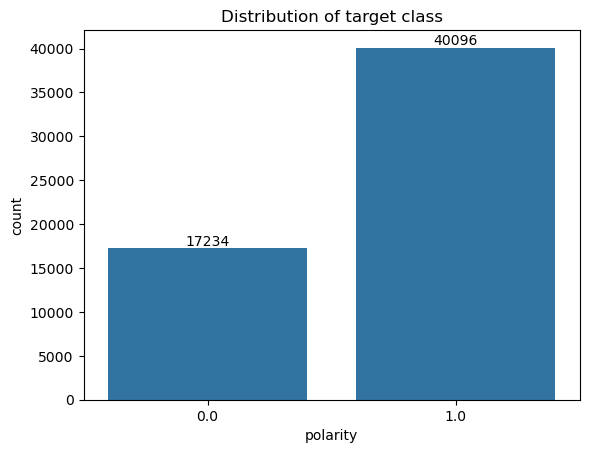

In [7]:
ax = sns.countplot(x='polarity', data=yelp_df)
ax.bar_label(ax.containers[0])
plt.title('Distribution of target class')
plt.show()

## 2. Machine Learning with VADER Sentiment Analysis

Let's first try using VADER, which is a sentiment analysis tool built into nltk, to transform textual data for use in machine learning models.

### 2.1 Calculate sentiment scores and add them to the dataframe

In [ ]:
sia = SentimentIntensityAnalyzer()
yelp_vader_df = yelp_df

yelp_vader_df['neg'] = yelp_vader_df['text'].apply(lambda x:sia.polarity_scores(x)['neg'])
yelp_vader_df['neu'] = yelp_vader_df['text'].apply(lambda x:sia.polarity_scores(x)['neu'])
yelp_vader_df['pos'] = yelp_vader_df['text'].apply(lambda x:sia.polarity_scores(x)['pos'])
yelp_vader_df['compound'] = yelp_vader_df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])

Now that we have the sentiment scores, we can drop the review text column.

In [9]:
yelp_vader_df = yelp_vader_df.drop('text', axis=1)

We now have a dataframe with numerical features we can use for training a ML model.

In [10]:
yelp_vader_df.head()

,polarity,neg,neu,pos,compound
0,1.0,0.004,0.753,0.242,0.9970
1,1.0,0.066,0.671,0.263,0.9690
2,1.0,0.000,0.590,0.410,0.9457
3,1.0,0.000,0.655,0.345,0.8176
4,1.0,0.042,0.716,0.242,0.9699


### 2.2 Logistic Regression Model

Split the data into X and y data.

In [11]:
X = yelp_vader_df.drop('polarity', axis=1)
y = yelp_vader_df['polarity']

Create training, validation, and test sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=103, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=103, stratify=y_test)

Fit the logistic regression model.

In [13]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

Let's see how it performs on the validation set.

In [14]:
y_val_log = log_reg.predict(X_val)
print(classification_report(y_val, y_val_log))

              precision    recall  f1-score   support

         0.0       0.82      0.63      0.71      1724
         1.0       0.86      0.94      0.90      4009

    accuracy                           0.85      5733
   macro avg       0.84      0.79      0.81      5733
weighted avg       0.85      0.85      0.84      5733



The overall accuracy is 85% on the validation set! Let's see how it performs on the test set.

In [15]:
y_test_log = log_reg.predict(X_test)
print(classification_report(y_test, y_test_log))

              precision    recall  f1-score   support

         0.0       0.81      0.64      0.72      1723
         1.0       0.86      0.94      0.90      4010

    accuracy                           0.85      5733
   macro avg       0.84      0.79      0.81      5733
weighted avg       0.84      0.85      0.84      5733



The model performed fairly similarly on the test set.

### 2.3 Decision Tree Model

We can use the same training/validation/test set splits that we used for the logistic regression model. Let's start by fitting the decision tree model.

In [16]:
dcsn_tree = DecisionTreeClassifier()
dcsn_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Let's see how it performs on the validation set.

In [17]:
y_val_dcsn = dcsn_tree.predict(X_val)
print(classification_report(y_val, y_val_dcsn))

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64      1724
         1.0       0.85      0.85      0.85      4009

    accuracy                           0.79      5733
   macro avg       0.75      0.75      0.75      5733
weighted avg       0.79      0.79      0.79      5733



The model's accuracy for the validation set is 79% -- pretty good, though worse than the logistic regression model. Let's try it on the test set.

In [18]:
y_test_dcsn = dcsn_tree.predict(X_test)
print(classification_report(y_test, y_test_dcsn))

              precision    recall  f1-score   support

         0.0       0.63      0.64      0.64      1723
         1.0       0.85      0.84      0.84      4010

    accuracy                           0.78      5733
   macro avg       0.74      0.74      0.74      5733
weighted avg       0.78      0.78      0.78      5733



The model has an overall accuracy of 78% on the test set.

### 2.4 Naive Bayes

Finally, let's try using the Naive Bayes model, which is commonly used for text classification problems.

In [19]:
bern_nb = BernoulliNB()
bern_nb.fit(X_train, y_train)

BernoulliNB()

The trained Naive Bayes model performs similarly on the validation and test sets, with an accuracy of 80%.

In [20]:
y_val_nb = bern_nb.predict(X_val)
print(classification_report(y_val, y_val_nb))

              precision    recall  f1-score   support

         0.0       0.91      0.37      0.52      1724
         1.0       0.78      0.98      0.87      4009

    accuracy                           0.80      5733
   macro avg       0.85      0.68      0.70      5733
weighted avg       0.82      0.80      0.77      5733



In [21]:
y_test_nb = bern_nb.predict(X_test)
print(classification_report(y_test, y_test_nb))

              precision    recall  f1-score   support

         0.0       0.91      0.36      0.52      1723
         1.0       0.78      0.98      0.87      4010

    accuracy                           0.80      5733
   macro avg       0.85      0.67      0.69      5733
weighted avg       0.82      0.80      0.77      5733



## 3. Machine learning with TF-IDF

Now let's try using the same models, but we'll use the data preprocessing methods learned in IS597 to prepare the textual data.

### 3.1 Preprocess the textual data

Make a copy of the Yelp dataframe to work with.

In [22]:
yelp_nb_df = yelp_df

Split the dataframe into the X and y columns.

In [23]:
X_data = yelp_nb_df['text']
y_data = yelp_nb_df['polarity']

Preprocess the textual data (X_data).

In [24]:
# Convert to lowercase letters
X_data = X_data.str.lower()    

# Remove punctuations
X_data = X_data.str.replace('[^\w\s]', '', regex=True)

# Tokenize sentences
X_data = X_data.apply(nltk.word_tokenize)

# Remove stopwords
stopword_list = stopwords.words("english")
X_data = X_data.apply(lambda x: [word for word in x if word not in stopword_list])

# Stemming
stemmer = PorterStemmer()
X_data = X_data.apply(lambda x: [stemmer.stem(y) for y in x])

# Remove unnecessary spaces
X_data = X_data.apply(lambda x: " ".join(x))

Split the data.

In [25]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data, y_data, test_size=0.2, random_state=103, stratify=y_data)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.5, random_state=103, stratify=y_test2)

Reset the indices.

In [26]:
X_train2=X_train2.reset_index(drop=True)
X_val2=X_val2.reset_index(drop=True)
X_test2=X_test2.reset_index(drop=True)
    
y_train2=y_train2.reset_index(drop=True)
y_val2=y_val2.reset_index(drop=True)
y_test2=y_test2.reset_index(drop=True)

Transform the text into numerical representations.

In [27]:
vectorizer = TfidfVectorizer(max_features=10000)

X_train_vect = vectorizer.fit_transform(X_train2)
X_val_vect = vectorizer.fit_transform(X_val2)
X_test_vect = vectorizer.transform(X_test2)

### 3.2 Logistic regression

Start by fitting the logistic regression model.

In [28]:
log_reg2 = LogisticRegression()
log_reg2.fit(X_train_vect, y_train2)

LogisticRegression()

The fitted model has an accuracy of ~62% on the validation and test sets.

In [29]:
y_val_log2 = log_reg2.predict(X_val_vect)
print(classification_report(y_val2, y_val_log2))

              precision    recall  f1-score   support

         0.0       0.34      0.24      0.28      1724
         1.0       0.71      0.80      0.75      4009

    accuracy                           0.63      5733
   macro avg       0.53      0.52      0.52      5733
weighted avg       0.60      0.63      0.61      5733



In [30]:
y_test_log2 = log_reg2.predict(X_test_vect)
print(classification_report(y_test2, y_test_log2))

              precision    recall  f1-score   support

         0.0       0.33      0.24      0.28      1723
         1.0       0.71      0.79      0.74      4010

    accuracy                           0.62      5733
   macro avg       0.52      0.51      0.51      5733
weighted avg       0.59      0.62      0.60      5733



### 3.3 Decision Tree

Let's fit the decision tree model.

In [31]:
dcsn_tree2 = DecisionTreeClassifier()
dcsn_tree2.fit(X_train_vect, y_train2)

DecisionTreeClassifier()

The model has an accuracy of 64% for the validation and test sets.

In [37]:
y_val_dcsn2 = dcsn_tree2.predict(X_val_vect)
print(classification_report(y_val2, y_val_dcsn2))

              precision    recall  f1-score   support

         0.0       0.35      0.23      0.28      1724
         1.0       0.71      0.81      0.76      4009

    accuracy                           0.64      5733
   macro avg       0.53      0.52      0.52      5733
weighted avg       0.60      0.64      0.61      5733



In [38]:
y_test_dcsn2 = dcsn_tree2.predict(X_test_vect)
print(classification_report(y_test2, y_test_dcsn2))

              precision    recall  f1-score   support

         0.0       0.37      0.26      0.30      1723
         1.0       0.72      0.81      0.76      4010

    accuracy                           0.64      5733
   macro avg       0.54      0.53      0.53      5733
weighted avg       0.61      0.64      0.62      5733



### 3.4 Naive Bayes model

Fit the Naive Bayes model.

In [34]:
bern_nb2 = BernoulliNB()
bern_nb2.fit(X_train_vect, y_train2)

BernoulliNB()

Let's see how the model performs on the validation set.

In [35]:
y_val_nb2 = bern_nb2.predict(X_val_vect)
print(classification_report(y_val2, y_val_nb2))

              precision    recall  f1-score   support

         0.0       0.38      0.42      0.40      1724
         1.0       0.74      0.70      0.72      4009

    accuracy                           0.62      5733
   macro avg       0.56      0.56      0.56      5733
weighted avg       0.63      0.62      0.62      5733



Looks like an overall accuracy of around 62%. Let's try the test set.

In [36]:
y_test_nb2 = bern_nb2.predict(X_test_vect)
print(classification_report(y_test2, y_test_nb2))

              precision    recall  f1-score   support

         0.0       0.38      0.41      0.39      1723
         1.0       0.74      0.72      0.73      4010

    accuracy                           0.62      5733
   macro avg       0.56      0.56      0.56      5733
weighted avg       0.63      0.62      0.63      5733



The Bernoulli Naive Bayes model also has an accuracy of 62% for the test set.